In [1]:
import xgboost as xgb
import pickle
from yahoofinancials import YahooFinancials
import pandas as pd
import numpy as np
import json
import seaborn as sns
from datetime import datetime
from datetime import date
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from helper import extract_data, create_features, sorted_correlations_with_gold, remove_correlated_features

In [2]:
with open("tickers.json", "r") as f:
    tickers = json.loads(f.read())

In [3]:
# load model
model = pickle.load(open("model/gold_price.pickle.dat", "rb"))

# load features
features_list = []

with open('model/features.txt', 'r') as f:
    for line in f:
        features_list.append(line[:-1])

In [4]:
n_days_ahead = 4

latest_date = (date.today()- timedelta(days=1))
end_date = latest_date.strftime("%Y-%m-%d")
start_date = (latest_date - timedelta(days=200)).strftime("%Y-%m-%d")
print("start_date: %s" %start_date)
print("end_date: %s" %end_date)
print("forecasting price of gold for %s" %(latest_date+ timedelta(days=n_days_ahead)).strftime("%Y-%m-%d"))

start_date: 2020-01-02
end_date: 2020-07-20
forecasting price of gold for 2020-07-24


In [5]:
infer_values = extract_data(start_date,end_date, tickers)
infer_values.tail()

,date,Gold,Silver,Crude Oil,S&P500,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Copper,Dollar Index,Volatility Index,MSCI EM ETF,Euro USD,Euronext100
196,2020-07-16,1797.8,19.52,40.76,3215.57,139.45,110.42,834.1,2.89,96.07,28.00,42.53,1.14,1008.60
197,2020-07-17,1812.1,19.75,40.57,3224.73,139.36,110.41,851.4,2.90,96.07,25.68,42.77,1.14,1006.22
198,2020-07-18,1812.1,19.75,40.57,3224.73,139.36,110.41,851.4,2.90,96.07,25.68,42.77,1.14,1006.22
199,2020-07-19,1810.5,19.75,40.63,3224.73,139.34,110.41,852.5,2.91,96.07,25.68,42.77,1.14,1006.22
200,2020-07-20,1810.5,19.75,40.63,3224.73,139.34,110.41,852.5,2.91,96.07,25.68,42.77,1.14,1006.22


In [6]:
features_list

['Gold_t-1',
 'Gold_t-7',
 'Gold_t-14',
 '10 Yr US T-Note futures_t-30',
 'Copper_t-2',
 'Euronext100_t-1',
 'Volatility Index_t-21',
 '2 Yr US T-Note Futures_t-2',
 'MSCI EM ETF_t-2',
 'MSCI EM ETF_t-3',
 'MSCI EM ETF_t-30',
 'Volatility Index_rocr_2',
 'Volatility Index_rocr_14']

In [7]:
infer_features = create_features(infer_values)
infer_features = infer_features[['date']+features_list]
infer_features.tail()

,date,Gold_t-1,Gold_t-7,Gold_t-14,10 Yr US T-Note futures_t-30,Copper_t-2,Euronext100_t-1,Volatility Index_t-21,2 Yr US T-Note Futures_t-2,MSCI EM ETF_t-2,MSCI EM ETF_t-3,MSCI EM ETF_t-30,Volatility Index_rocr_2,Volatility Index_rocr_14
16,2020-07-16,-0.009477,-0.012523,0.010057,0.005190,-0.023649,-0.004697,-0.130975,0.000272,-0.011160,-0.009779,0.075892,-0.167905,0.747839
17,2020-07-17,0.007954,0.004601,0.018091,0.006645,0.003460,-0.002360,-0.260582,0.000000,-0.008577,-0.005580,0.071661,1.105824,1.146743
18,2020-07-18,0.000000,0.004601,0.018091,0.005556,0.003460,0.000000,-0.260582,-0.000091,0.005643,-0.008577,0.071124,-0.000000,-0.000000
19,2020-07-19,-0.000883,0.003547,0.013264,0.003674,0.003448,0.000000,-0.260582,0.000000,0.000000,0.005643,0.071393,-0.000000,-0.000000
20,2020-07-20,0.000000,0.004773,0.011453,0.003674,0.003448,0.000000,-0.191945,0.000000,0.000000,0.000000,0.071393,-0.000000,-0.000000


In [8]:
output = model.predict(infer_features.iloc[:,1:])
df_predict = pd.DataFrame()
df_predict['date'] = infer_features['date']
df_predict['return_prediction'] = output


In [9]:
results = pd.DataFrame()
results['date']  = pd.date_range(start=infer_features['date'].iloc[0], end= infer_features['date'].iloc[-1] + timedelta(days=n_days_ahead))
results = pd.merge(left=results, right=infer_values[['date','Gold']], on='date', how='left')
results = pd.merge(left=results, right=df_predict[['date','return_prediction']], on='date', how='left')
results ['predicted_price'] = results['Gold']*(results ['return_prediction']+1)
results ['predicted_price'] = results ['predicted_price'].shift(n_days_ahead)
results.tail(10)

,date,Gold,return_prediction,predicted_price
15,2020-07-15,1815.0,-0.002119,1804.188344
16,2020-07-16,1797.8,-0.000586,1803.255115
17,2020-07-17,1812.1,0.000542,1797.872654
18,2020-07-18,1812.1,-0.000024,1811.764642
19,2020-07-19,1810.5,-0.000024,1811.154331
20,2020-07-20,1810.5,-0.000613,1796.745680
21,2020-07-21,NaN,NaN,1813.081807
22,2020-07-22,NaN,NaN,1812.057336
23,2020-07-23,NaN,NaN,1810.457374
24,2020-07-24,NaN,NaN,1809.390966


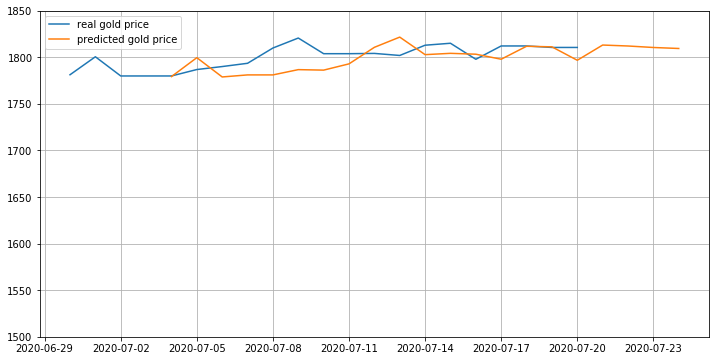

In [10]:
plt.figure(figsize=(12,6))
plt.plot(results['date'], results['Gold'], label="real gold price")
plt.plot(results['date'], results['predicted_price'], label="predicted gold price")
plt.grid()
plt.ylim([1500,1850])
plt.legend()

In [11]:
prediction_date = '2020-07-24'

In [12]:
print("Predicted price for date %s: %2.2f" %(prediction_date,results[results['date']==prediction_date]['predicted_price'].values[0]))

Predicted price for date 2020-07-24: 1809.39
